In [1]:
from utils import get_info_state, activate_memory_growth, print_player0_obs; activate_memory_growth(cpu=False)
import os
from datetime import datetime
import tensorflow as tf
import clubs
import clubs_gym
import gym
from jupyter_nb_utils import cumulative_reward, plot_results
from poker_agent import TensorflowAgent, Bet_Fct
from random import shuffle
import numpy as np
from IPython.display import clear_output

%matplotlib inline

[INFO] - Models trained on GPU, with memory growth activated.


In [2]:
# create result path
t_start = datetime.now()
datetime_str = t_start.strftime('%Y%m%d-%H%M%S')
results_dir = os.path.join('results/', datetime_str + '_games-agains-bot')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

# INFO

With this Jupyter Notebook, you can <b>play against our trained bot</b> while receiving advices for what action he would have choosen on your turn. Enjoy :)

In [3]:
start_stack = 1_000

# Create the Poker Environment

Parameter settings for the Agents

In [4]:
# model paths
trained_model_path = 'trained_models/action_2_models/training_batch_size_512/advantage-network_player-0_CRF-iteration-1'

# model type
model_output_types = ['action', 'action_2', 'bet']
model_type = model_output_types[1]
bet_fct = Bet_Fct(model_type)

# Agent used for opponent
agent_fct = TensorflowAgent

## Parameter settings for the poker (clubs_gym) environment

In [5]:
# Set game parameters
env_str = 'LDRL-Poker-v0'
num_players = 2
num_streets = 2
num_raises = 3
num_actions = 4
num_cards = [2, 3]
num_suits = 4
num_ranks = 13

# automatic setting of some params
n_community_cards = [0] + num_cards[1:]
n_cards_for_hand = min(5, sum(num_cards))
max_bet_number = num_streets * (num_raises + ((num_players-1) * 2))

# environment params dict
config_dict = {'num_players': num_players,
               'num_streets': num_streets,
               'blinds': [1, 2],
               'antes': 0,
               'raise_sizes': 'pot',
               'num_raises': num_raises,
               'num_suits': num_suits,
               'num_ranks': num_ranks,
               'num_hole_cards': num_cards[0],
               'mandatory_num_hole_cards': 0,
               'num_community_cards': n_community_cards,
               'start_stack': start_stack,
               'num_cards_for_hand': n_cards_for_hand}

## Initialization of the Poker environment

In [6]:
clubs_gym.envs.register({env_str: config_dict})
env = gym.make(env_str)
env.register_agents([agent_fct(model_save_path) for model_save_path in [trained_model_path, trained_model_path]])

# The Game traversal

The game consists of <b>2 betting rounds</b> with each having <b>3 possible raises</b> in total. The card deck is a normal <b>poker deck</b> (4 suits, 13 ranks, 52 cars). The amount for calling as well as the min and max raise sizes are displayed. Just enter the amount of chips you wanna bet (0 = fold, but sometimes call, depends on the game state) and hit enter each time it's your turn. Tip: You can set the amount of chips you and the bot own at the top of this notebook.

In [7]:
# data logs
reward_history = None
action_history_p0 = []
action_history_p1 = []
preflop_history_p0 = []
preflop_history_p1 = []

In [11]:
player = 0
bot = 1

# how many games
clear_output(wait=True)
how_many_games = input('[Info] - You are player 0\nHow many games you wanna play? Hit Enter to start.\nGames:')

# Start the Game
for i in range(int(how_many_games)):
    counter = 1

    print(f'\n+++++++++++++++++++ [Game {i}] +++++++++++++++++++\n')
    print(f'=================== [Round {counter}] ===================\n')

    obs = env.reset()      
    history = []
    
    while True:
        counter += 1
          
        # non terminal-state       
        if all(obs['active']) and not obs['action'] == -1:
            # Players action
            if obs['action'] == player:
                # choose bet
                info_state = get_info_state(obs, history, max_bet_number, env.dealer.num_streets, config_dict)
                action_idx = env.act(info_state)
                bet_bot = bet_fct(action_idx, obs)

                print_player0_obs(obs, num_suits)    
                bet = int(input(f'The Bot would bet {bet_bot} chips.\nPlace your amount of chips: '))
                print()
                # make bet within environment
                obs, rewards, done, _ = env.step(bet)
                 
                print(f'=================== [Round {counter}] ===================\n')

            # Bot action
            else:
                # get bet
                info_state = get_info_state(obs, history, max_bet_number, env.dealer.num_streets, config_dict)
                action_idx = env.act(info_state)
                bet = bet_fct(action_idx, obs)

                # make bet within environment
                obs, rewards, done, _ = env.step(bet)

                print(f"Bot's bet: {bet}", end='\n\n')
                print(f'=================== [Round {counter}] ===================\n')
                
                bot_cards = obs['hole_cards']

            # save actions for plots
            if obs['action'] == 0:
                action_history_p0.append(bet)
                if not obs['community_cards']:
                    preflop_history_p0.append(bet)
            else:
                action_history_p1.append(bet)
                if not obs['community_cards']:
                    preflop_history_p1.append(bet)
            history.append(bet) 
        
        # terminal state
        else:               
            # save results      
            if reward_history is None:
                reward_history = np.array([rewards])
            else:
                reward_history = np.append(reward_history, [rewards], axis=0)
            print('\n[INFO] - End of the Game.')
            print(f'Bot cards: {bot_cards}')
            print(f'Payoffs: Player_0 {rewards[0]}, Player_1 {rewards[1]}')
                
            break


[Info] - You are player 0
How many games you wanna play? Hit Enter to start.
Games:1

+++++++++++++++++++ [Game 0] +++++++++++++++++++

=================== [Round 1] ===================

------------------ game Stats ------------------
community_cards: []
Dealer/Button: Player 0
Pot: 3
Commits: player_0 1, player_1 2

--------------- player 0's turn ---------------
hole_cards: [Card (140298801418832): 6♦, Card (140294332818384): 4♠]
fold/check: 0, call: 1, min_raise: 3, max_raise: 5
The Bot would bet 0 chips.
Place your amount of chips: 0

=================== [Round 2] ===================


[INFO] - End of the Game.
Bot cards: [Card (140298801421904): 6♣, Card (140294305215440): Q♥]
Payoffs: Player_0 -1, Player_1 1


# Evaluate the Poker Game

You are player_0 and the bot player_1. Just decide if you wanna save the plots and run the script below.

/home/janosch/.miniconda3/envs/poker/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


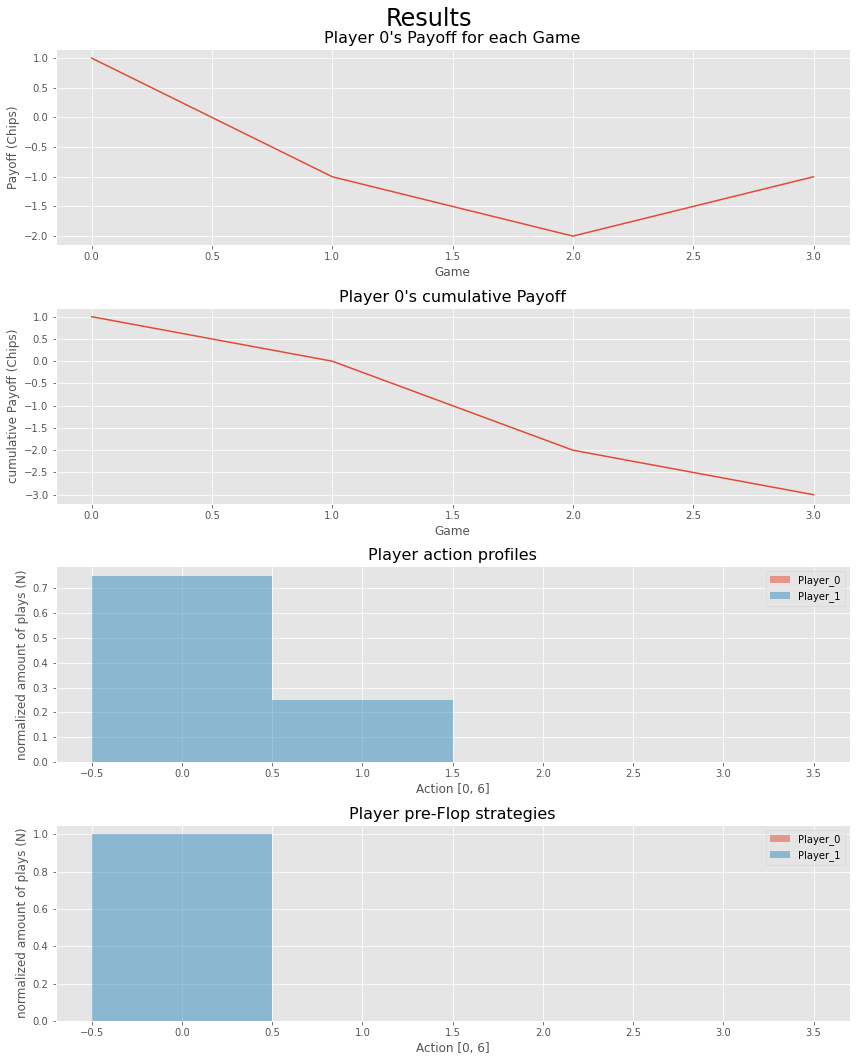

In [12]:
save_plot = True

if save_plot:
    fn = 'game_results.svg'
save_path = os.path.join(results_dir, fn)

# create plot
plot_results(reward_history, num_actions, action_history_p0,
             action_history_p1, preflop_history_p0, preflop_history_p1, save_path)